# 1. Imports and setup

In [1]:
# Imports and setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import gc
from tqdm.notebook import tqdm
import time
import threading
from concurrent.futures import ThreadPoolExecutor

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
DATA_PATH = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TRAIN_LABELS = os.path.join(DATA_PATH, "train_labels.csv")
TEST_PATH = os.path.join(DATA_PATH, "test")
SUBMISSION_PATH = "/kaggle/working/submission.csv"

# Detection parameters 
CONFIDENCE_THRESHOLD = 0.35  # Threshold for considering a detection
NMS_IOU_THRESHOLD = 0.2     # IoU threshold for 3D NMS clustering
MAX_DETECTIONS_PER_TOMO = 1 # Maximum number of motors per tomogram (for test set)
IMAGE_SIZE = (224, 224)     # Size to resize slices to
BATCH_SIZE = 6              # Default batch size, will be adjusted dynamically

2025-04-28 00:51:06.710996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745801466.920293      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745801466.977900      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Disable mixed precision globally to avoid type mismatches
tf.keras.mixed_precision.set_global_policy('float32')

# 2. Memory managment and utitlity functions

In [3]:
# Memory management and GPU optimization
def clear_memory():
    """Clear memory to prevent OOM errors"""
    gc.collect()
    
    # If GPU is available, also clear GPU memory
    if tf.config.list_physical_devices('GPU'):
        tf.keras.backend.clear_session()

def optimize_gpu():
    """Configure GPU settings for optimal performance with safe mixed precision"""
    # Check for GPU availability
    gpus = tf.config.list_physical_devices('GPU')
    
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU(s)")
        
        # Enable memory growth to avoid OOM errors
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"Memory growth enabled for {gpu}")
            except RuntimeError as e:
                print(f"Error setting memory growth: {e}")
        
        # For mixed precision, we'll disable policy and use explicit type casting instead
        # This avoids incompatible type errors
        print("Using explicit type casting for mixed precision operations")
        
        # Set XLA optimization for faster execution
        tf.config.optimizer.set_jit(True)
        print("XLA JIT compilation enabled")
        
        # Estimate reasonable batch size based on GPU memory
        batch_size = 6  # Default batch size for GPU
        return batch_size, True
    else:
        print("No GPU found")
        return 4, False  # Reduced batch size for CPU

# Timer class for profiling
class Timer:
    def __init__(self, name):
        self.name = name
        self.start_time = None
    
    def __enter__(self):
        self.start_time = time.time()
        return self
    
    def __exit__(self, *args):
        elapsed = time.time() - self.start_time
        print(f"[TIMER] {self.name}: {elapsed:.3f}s")

# 3. Image processing

In [4]:
# Image processing functions
def normalize_slice(slice_data):
    """Normalize slice data using 2nd and 98th percentiles for better contrast"""
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)

def enhance_slice(slice_img):
    """Apply preprocessing to enhance motor features in a slice"""
    # Convert to uint8 if needed
    if slice_img.dtype != np.uint8:
        slice_img = slice_img.astype(np.uint8)
        
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(slice_img)
    
    # Apply light Gaussian blur to reduce noise
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # Apply histogram equalization for better feature visibility
    enhanced = cv2.equalizeHist(enhanced)
    
    return enhanced

def preload_image_batch(file_paths):
    """Preload a batch of images to CPU memory"""
    images = []
    for path in file_paths:
        try:
            # First try OpenCV
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                # Fallback to PIL
                img = np.array(Image.open(path).convert('L'))
            
            # Apply enhancement
            img = enhance_slice(img)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            # Add empty image as fallback
            images.append(np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1]), dtype=np.uint8))
    return images

# 4. Data prep and loading

In [5]:
# Dataset preparation and loading
def create_train_val_split(labels_df, val_fraction=0.2, random_state=42):
    """Split the data into training and validation sets by tomogram ID"""
    unique_ids = labels_df['tomo_id'].unique()
    np.random.seed(random_state)
    np.random.shuffle(unique_ids)
    
    split_idx = int(len(unique_ids) * (1 - val_fraction))
    train_ids = unique_ids[:split_idx]
    val_ids = unique_ids[split_idx:]
    
    return train_ids, val_ids

# Data generator for efficient loading
class TomogramDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, tomo_ids, labels_df=None, batch_size=1, shuffle=True,
                 slice_sampling_factor=0.5, max_slices=64, resize=(320, 320),
                 is_test=False, augment=False):
        
        self.tomo_ids = tomo_ids
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.slice_sampling_factor = slice_sampling_factor
        self.max_slices = max_slices
        self.resize = resize
        self.is_test = is_test
        self.augment = augment
        self.data_path = TEST_PATH if is_test else TRAIN_PATH
        
        # Precompute tomogram metadata for more efficient loading
        self.tomo_metadata = {}
        
        for tomo_id in self.tomo_ids:
            # Get info about this tomogram
            if not is_test and labels_df is not None:
                tomo_info = labels_df[labels_df['tomo_id'] == tomo_id]
                if len(tomo_info) > 0:
                    tomo_info = tomo_info.iloc[0]
                    self.tomo_metadata[tomo_id] = {
                        'shape': (
                            int(tomo_info['Array shape (axis 0)']),
                            int(tomo_info['Array shape (axis 1)']),
                            int(tomo_info['Array shape (axis 2)'])
                        ),
                        'spacing': float(tomo_info['Voxel spacing']),
                        'motor_count': int(tomo_info['Number of motors'])
                    }
            else:
                # For test data, determine the shape when loading
                folder_path = os.path.join(self.data_path, tomo_id)
                slice_files = sorted([f for f in os.listdir(folder_path) 
                                     if f.startswith('slice_') and f.endswith('.jpg')])
                
                # Sample first slice to get dimensions
                sample_path = os.path.join(folder_path, slice_files[0])
                with Image.open(sample_path) as img:
                    width, height = img.size
                
                self.tomo_metadata[tomo_id] = {
                    'shape': (len(slice_files), height, width),
                    'slice_count': len(slice_files)
                }
        
        self.on_epoch_end()
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.tomo_ids) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Get tomogram IDs for this batch
        batch_ids = self.tomo_ids[index * self.batch_size:
                                  min((index + 1) * self.batch_size, len(self.tomo_ids))]
        
        # Initialize batch arrays
        batch_x = []
        batch_y = []
        
        # Generate data for each tomogram in the batch
        for tomo_id in batch_ids:
            # Load the 3D volume
            volume = self._load_tomogram(tomo_id)
            batch_x.append(volume)
            
            if not self.is_test and self.labels_df is not None:
                # Get the labels for training data
                motor_locations = self._get_motor_locations(tomo_id)
                batch_y.append(motor_locations)
        
        # Convert to numpy arrays
        batch_x = np.array(batch_x, dtype=np.float32)
        
        if not self.is_test and self.labels_df is not None:
            batch_y = np.array(batch_y, dtype=np.float32)
            return batch_x, batch_y
        else:
            return batch_x, batch_ids
    
    def _load_tomogram(self, tomo_id):
        """Load a tomogram with sampling to fit in memory"""
        folder_path = os.path.join(self.data_path, tomo_id)
        
        # Get all slice files
        slice_files = sorted([f for f in os.listdir(folder_path) 
                             if f.startswith('slice_') and f.endswith('.jpg')])
        
        # Use higher sampling for test data
        actual_sampling_factor = 0.8 if self.is_test else self.slice_sampling_factor
        
        # Apply slice sampling to reduce memory usage
        if actual_sampling_factor < 1.0:
            num_slices = max(int(len(slice_files) * actual_sampling_factor), 1)
            indices = np.linspace(0, len(slice_files) - 1, num_slices, dtype=int)
            slice_files = [slice_files[i] for i in indices]
        
        # Ensure we have exactly max_slices
        if self.max_slices:
            if len(slice_files) > self.max_slices:
                # If more slices than needed, sample evenly
                indices = np.linspace(0, len(slice_files) - 1, self.max_slices, dtype=int)
                slice_files = [slice_files[i] for i in indices]
            elif len(slice_files) < self.max_slices:
                # If fewer slices than needed, pad with repeats of nearby slices
                needed = self.max_slices - len(slice_files)
                padding = []
                for i in range(needed):
                    idx = min(i % len(slice_files), len(slice_files)-1)
                    padding.append(slice_files[idx])
                slice_files = slice_files + padding
        
        # Initialize volume with correct shape
        height, width = self.resize
        volume = np.zeros((len(slice_files), height, width, 1), dtype=np.float32)
        
        # Process each slice
        for i, slice_file in enumerate(slice_files):
            try:
                # Load and process the slice efficiently
                slice_path = os.path.join(folder_path, slice_file)
                
                # Using PIL for loading
                with Image.open(slice_path) as img:
                    if self.resize:
                        img = img.resize(self.resize, Image.BICUBIC)
                    
                    # Convert to numpy array
                    img_array = np.array(img.convert('L'), dtype=np.float32)
                    
                    # Apply enhancement for better feature visibility
                    img_array = enhance_slice(img_array.astype(np.uint8)).astype(np.float32)
                    
                    # Normalize to [0,1] range
                    img_array = img_array / 255.0
                
                # Add channel dimension
                img_array = np.expand_dims(img_array, axis=-1)
                
                # Store in volume
                volume[i, :, :, 0] = img_array[:, :, 0]
                
                # Force garbage collection periodically
                if i % 20 == 0:
                    gc.collect()
            
            except Exception as e:
                print(f"Error loading slice {slice_file} from {tomo_id}: {e}")
                # Fill with zeros on error
                volume[i, :, :, 0] = 0
        
        # Apply data augmentation if needed
        if self.augment and not self.is_test:
            volume = self._augment_volume(volume)
        
        return volume
    
    def _augment_volume(self, volume):
        """Apply simple 3D data augmentation to the volume"""
        # Only apply augmentation with 50% probability
        if np.random.rand() < 0.5:
            return volume
        
        # Apply a random transformation
        aug_type = np.random.choice(['flip', 'rotate', 'noise'])
        
        if aug_type == 'flip':
            # Flip in y or x direction
            axis = np.random.choice([1, 2])
            volume = np.flip(volume, axis=axis)
        
        elif aug_type == 'rotate':
            # 90, 180, or 270 degree rotation in the y-x plane
            k = np.random.choice([1, 2, 3])
            volume = np.rot90(volume, k=k, axes=(1, 2))
        
        elif aug_type == 'noise':
            # Add random noise
            noise_level = np.random.uniform(0.01, 0.05)
            noise = np.random.normal(0, noise_level, volume.shape)
            volume = np.clip(volume + noise, 0, 1)
        
        return volume
    
    def _get_motor_locations(self, tomo_id):
        """Get motor locations with coordinates normalized to [0,1]"""
        # Get all motor labels for this tomogram
        tomo_labels = self.labels_df[self.labels_df['tomo_id'] == tomo_id]
        
        # Get tomogram shape from metadata
        if tomo_id in self.tomo_metadata:
            tomo_shape = self.tomo_metadata[tomo_id]['shape']
        else:
            # Fallback shape if metadata not available
            tomo_shape = (100, 100, 100)  # Default values
        
        # For simplified detection, we'll use a single tensor
        # [has_motor, z, y, x] where coordinates are normalized to [0,1]
        # Return shape will be [1, 4]
        motor_locations = np.zeros((1, 4), dtype=np.float32)
        
        # If no motors, return zero tensor
        if len(tomo_labels) == 0:
            return motor_locations
        
        # For simplicity, use only first motor if multiple exist
        motor = tomo_labels.iloc[0]
        
        # Extract 3D coordinates
        z = float(motor['Motor axis 0'])
        y = float(motor['Motor axis 1'])
        x = float(motor['Motor axis 2'])
        
        # Skip invalid coordinates
        if z < 0 or y < 0 or x < 0:
            return motor_locations
        
        # Normalize coordinates to [0,1] range
        z_norm = z / tomo_shape[0]
        y_norm = y / tomo_shape[1]
        x_norm = x / tomo_shape[2]
        
        # Store [has_motor, z_norm, y_norm, x_norm]
        motor_locations[0] = [1.0, z_norm, y_norm, x_norm]
        
        return motor_locations
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.tomo_ids)

# 5. Model

In [6]:
# Simple 3D CNN for motor detection
def build_3d_detection_model(input_shape):
    """Build a 3D CNN model for motor detection"""
    # Start with normalized inputs [0,1]
    inputs = layers.Input(shape=input_shape)
    
    # Encoder - downsampling path
    # Block 1
    x = layers.Conv3D(16, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Block 2
    x = layers.Conv3D(32, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Block 3
    x = layers.Conv3D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Block 4
    x = layers.Conv3D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Global features
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.3)(x)
    
    # Detection head - outputs a flat tensor with 4 values
    outputs = layers.Dense(4)(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# 6. loss function and metrics

In [7]:
# Simplified loss function for motor detection with mixed precision handling
def motor_detection_loss(y_true, y_pred):
    """
    Custom loss function for 3D motor detection with mixed precision support
    
    Args:
        y_true: Ground truth tensor 
        y_pred: Predicted tensor
        
    Returns:
        Combined loss value
    """
    # Cast both tensors to same type (float32) to avoid mixed precision issues
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Reshape tensors if needed to ensure consistent shape
    y_true = tf.reshape(y_true, [-1, 4])
    y_pred = tf.reshape(y_pred, [-1, 4])
    
    # Split into confidence and coordinates
    true_conf = y_true[:, 0:1]  # Shape: [batch_size, 1]
    pred_conf = y_pred[:, 0:1]  # Shape: [batch_size, 1]
    true_coords = y_true[:, 1:4]  # Shape: [batch_size, 3]
    pred_coords = y_pred[:, 1:4]  # Shape: [batch_size, 3]
    
    # Binary cross-entropy loss for confidence
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    conf_loss = bce(true_conf, pred_conf)
    
    # Mean squared error loss for coordinates, but only when motor exists
    # Create a mask for samples with motors
    motor_mask = tf.cast(true_conf > 0.5, tf.float32)
    
    # Compute coordinate loss only for positive samples
    coord_error = tf.reduce_sum(tf.square(true_coords - pred_coords), axis=1, keepdims=True)
    
    # Apply mask and take mean
    masked_error = coord_error * motor_mask
    coord_loss = tf.reduce_sum(masked_error) / (tf.reduce_sum(motor_mask) + 1e-7)
    
    # Combine losses with weighting
    # Coordinate loss is weighted higher to ensure accurate localization
    total_loss = conf_loss + 5.0 * coord_loss
    
    return total_loss

# Custom metrics for training with mixed precision support
def detection_accuracy(y_true, y_pred):
    """Accuracy of motor detection with mixed precision support"""
    # Cast to same type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Reshape if needed
    y_true = tf.reshape(y_true, [-1, 4])
    y_pred = tf.reshape(y_pred, [-1, 4])
    
    # Get confidence values
    true_conf = y_true[:, 0]
    pred_conf = y_pred[:, 0]
    
    # Convert to binary predictions
    true_positive = tf.cast(true_conf > 0.5, tf.float32)
    pred_positive = tf.cast(pred_conf > 0.5, tf.float32)
    
    # Compute accuracy
    correct = tf.cast(tf.equal(true_positive, pred_positive), tf.float32)
    accuracy = tf.reduce_mean(correct)
    
    return accuracy

def coordinate_error(y_true, y_pred):
    """Mean coordinate error for true positives with mixed precision support"""
    # Cast to same type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Reshape if needed
    y_true = tf.reshape(y_true, [-1, 4])
    y_pred = tf.reshape(y_pred, [-1, 4])
    
    # Get confidence and coordinates
    true_conf = y_true[:, 0]
    pred_conf = y_pred[:, 0]
    true_coords = y_true[:, 1:4]
    pred_coords = y_pred[:, 1:4]
    
    # Only compute for true positives
    mask = tf.logical_and(true_conf > 0.5, pred_conf > 0.5)
    mask = tf.cast(mask, tf.float32)
    
    # Expand mask for element-wise multiplication
    mask_expanded = tf.expand_dims(mask, axis=-1)
    mask_expanded = tf.tile(mask_expanded, [1, 3])
    
    # Apply mask to coordinates before computing difference
    masked_true_coords = true_coords * mask_expanded
    masked_pred_coords = pred_coords * mask_expanded
    
    # Calculate squared differences safely
    squared_diff = tf.reduce_sum(tf.square(masked_true_coords - masked_pred_coords), axis=1)
    
    # Mean error over true positives
    total_true_pos = tf.reduce_sum(mask) + 1e-7  # Avoid division by zero
    mean_error = tf.reduce_sum(tf.sqrt(squared_diff) * mask) / total_true_pos
    
    return mean_error

# 7.  Train model

In [8]:
# Training function
def train_model(train_generator, val_generator, input_shape, epochs=20, 
                learning_rate=0.001, model_path='best_motor_model.keras'):
    """Train the motor detection model"""
    # Disable mixed precision globally to avoid type mismatches
    tf.keras.mixed_precision.set_global_policy('float32')
    
    # Create model
    model = build_3d_detection_model(input_shape)
    
    # Use Adam optimizer without dtype parameter
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile model with custom loss and metrics
    model.compile(
        optimizer=optimizer,
        loss=motor_detection_loss,
        metrics=[detection_accuracy, coordinate_error],
        # Disable JIT compilation for loss function
        jit_compile=False
    )
    
    # Print model summary
    model.summary()
    
    # Callbacks
    callbacks = [
        # Model checkpoint to save best model
        tf.keras.callbacks.ModelCheckpoint(
            model_path, 
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Reduce LR on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Train the model
    with Timer("Model training"):
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
    
    # Save final model if it's better than checkpoint
    if not os.path.exists(model_path):
        model.save(model_path)
        print(f"Final model saved to {model_path}")
    
    return model, history

# 8. inference and predictions

In [9]:
# 3D Non-Maximum Suppression
def perform_3d_nms(detections, iou_threshold=NMS_IOU_THRESHOLD):
    """
    Perform 3D Non-Maximum Suppression to merge nearby detections
    
    Args:
        detections: List of dictionaries with keys 'z', 'y', 'x', 'confidence'
        iou_threshold: Distance threshold for suppression
        
    Returns:
        List of detections after NMS
    """
    if not detections:
        return []
    
    # Sort by confidence (highest first)
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    
    # List to store final detections after NMS
    final_detections = []
    
    # Define 3D distance function
    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 + 
                      (d1['y'] - d2['y'])**2 + 
                      (d1['x'] - d2['x'])**2)
    
    # Maximum distance threshold (based on box size)
    box_size = 24  # Approximate motor size
    distance_threshold = box_size * iou_threshold
    
    # Process each detection
    while detections:
        # Take the detection with highest confidence
        best_detection = detections.pop(0)
        final_detections.append(best_detection)
        
        # Filter out detections that are too close to the best detection
        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold]
    
    return final_detections

# Progressive sampling for efficient inference
def progressive_sampling_detection(tomo_id, model, initial_sampling=0.2, max_sampling=0.8):
    """
    Progressive sampling strategy for efficient motor detection in large tomograms
    
    Args:
        tomo_id: Tomogram ID to process
        model: Trained detection model
        initial_sampling: Initial sampling ratio for coarse scan
        max_sampling: Maximum sampling ratio for fine-grained scan
        
    Returns:
        Dictionary with detection results
    """
    print(f"Processing tomogram {tomo_id} with progressive sampling")
    
    # Get all slice files for this tomogram
    tomo_dir = os.path.join(TEST_PATH, tomo_id)
    all_slices = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    total_slices = len(all_slices)
    
    print(f"Found {total_slices} total slices for tomogram {tomo_id}")
    
    # STAGE 1: Initial coarse sampling
    coarse_count = int(total_slices * initial_sampling)
    print(f"STAGE 1: Performing coarse sampling with {coarse_count} slices ({initial_sampling*100:.1f}%)")
    
    # Sample evenly spaced slices for initial scan
    coarse_indices = np.linspace(0, total_slices-1, coarse_count, dtype=int)
    coarse_slices = [all_slices[i] for i in coarse_indices]
    
    # In the progressive_sampling_detection function:
    coarse_generator = TomogramDataGenerator(
        tomo_ids=[tomo_id],
        batch_size=1,
        slice_sampling_factor=initial_sampling,
        max_slices=150,  # Match training value (150)
        resize=IMAGE_SIZE,
        is_test=True
    )
    
    # Run inference on coarse scan
    with Timer("Coarse inference"):
        x_batch, _ = coarse_generator[0]
        coarse_predictions = model.predict(x_batch, verbose=0)
    
    # Process coarse predictions
    coarse_detections = []
    
    # Reshape predictions if needed
    coarse_predictions = np.reshape(coarse_predictions, (-1, 4))
    
    # Extract confidence from first element
    confidence = coarse_predictions[0, 0]
    
    if confidence >= CONFIDENCE_THRESHOLD:
        # Get coordinates (normalized)
        z_norm, y_norm, x_norm = coarse_predictions[0, 1:4]
        
        # Convert to original coordinates
        z = z_norm * total_slices
        
        # Get the original dimensions from the first slice
        sample_path = os.path.join(tomo_dir, all_slices[0])
        with Image.open(sample_path) as img:
            width, height = img.size
        
        y = y_norm * height
        x = x_norm * width
        
        # Store detection
        coarse_detections.append({
            'z': z,
            'y': y,
            'x': x,
            'confidence': float(confidence)
        })
    
    # STAGE 2: Fine-grained sampling if needed
    fine_detections = []
    if coarse_detections:
        print(f"STAGE 2: Found {len(coarse_detections)} potential detections in coarse scan")
        
        # Define region of interest around the detection
        z_mean = coarse_detections[0]['z']
        z_window = total_slices * 0.2  # 20% of total slices as window
        
        # Define region bounds
        z_min = max(0, int(z_mean - z_window/2))
        z_max = min(total_slices, int(z_mean + z_window/2))
        
        # Calculate how many additional slices to sample
        additional_count = int(total_slices * max_sampling) - coarse_count
        
        if additional_count > 0:
            # Sample more densely in the region of interest
            region_size = z_max - z_min
            fine_indices = np.linspace(z_min, z_max, min(additional_count, region_size), dtype=int)
            
            # Filter out already processed indices
            fine_indices = [i for i in fine_indices if i not in coarse_indices]
            fine_slices = [all_slices[i] for i in fine_indices]
            
            print(f"Sampling {len(fine_slices)} additional slices in region of interest")
            
            # Process each fine slice individually
            for i, slice_file in enumerate(fine_slices):
                slice_path = os.path.join(tomo_dir, slice_file)
                slice_z = int(slice_file.split('_')[1].split('.')[0])
                
                # Load and preprocess the slice
                with Image.open(slice_path) as img:
                    if IMAGE_SIZE:
                        img = img.resize(IMAGE_SIZE, Image.BICUBIC)
                    img_array = np.array(img.convert('L'), dtype=np.float32)
                    img_array = enhance_slice(img_array.astype(np.uint8)).astype(np.float32)
                    img_array = img_array / 255.0  # Normalize to [0,1]
                
                # Add batch and channel dimensions
                img_tensor = np.expand_dims(np.expand_dims(img_array, axis=0), axis=-1)
                
                # Create mini-volume for processing
                mini_volume = np.zeros((1, 150, IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.float32)
                # Fill all 150 slices with the same image
                for j in range(150):
                    mini_volume[0, j, :, :, 0] = img_tensor[0, :, :, 0]
                
                # Run inference
                prediction = model.predict(mini_volume, verbose=0)
                prediction = np.reshape(prediction, (-1, 4))
                
                # Check confidence
                confidence = prediction[0, 0]
                if confidence >= CONFIDENCE_THRESHOLD * 0.8:  # Lower threshold for fine-grained scan
                    # Get normalized coordinates
                    _, y_norm, x_norm = prediction[0, 1:4]
                    
                    # Convert to original coordinates
                    y = y_norm * height
                    x = x_norm * width
                    
                    # Store detection with actual slice number
                    fine_detections.append({
                        'z': slice_z,
                        'y': y,
                        'x': x,
                        'confidence': float(confidence)
                    })
    else:
        print("No potential detections found in coarse scan, trying wider search")
        
        # If no detections in coarse scan, try sampling more slices
        medium_sampling = (initial_sampling + max_sampling) / 2
        medium_count = int(total_slices * medium_sampling) - coarse_count
        
        if medium_count > 0:
            # Sample additional slices uniformly
            all_indices = set(range(total_slices))
            available_indices = list(all_indices - set(coarse_indices))
            
            # Sort available indices to ensure deterministic behavior
            available_indices.sort()
            
            # Sample systematically
            if len(available_indices) > medium_count:
                step = len(available_indices) // medium_count
                medium_indices = available_indices[::step][:medium_count]
            else:
                medium_indices = available_indices
            
            medium_slices = [all_slices[i] for i in medium_indices]
            print(f"Trying {len(medium_slices)} additional slices in medium-resolution scan")
            
            # Batch process medium slices
            for i in range(0, len(medium_slices), 16):
                batch_slices = medium_slices[i:i+16]
                batch_paths = [os.path.join(tomo_dir, s) for s in batch_slices]
                batch_z = [int(s.split('_')[1].split('.')[0]) for s in batch_slices]
                
                # Load and preprocess batch
                batch_data = []
                for path in batch_paths:
                    with Image.open(path) as img:
                        if IMAGE_SIZE:
                            img = img.resize(IMAGE_SIZE, Image.BICUBIC)
                        img_array = np.array(img.convert('L'), dtype=np.float32)
                        img_array = enhance_slice(img_array.astype(np.uint8)).astype(np.float32)
                        img_array = img_array / 255.0  # Normalize to [0,1]
                        batch_data.append(img_array)
                
                # Create mini-volume for batch
                batch_length = len(batch_data)
                if batch_length < 16:  # Pad if needed
                    padding = [batch_data[-1]] * (16 - batch_length)
                    batch_data.extend(padding)
                
                # Create mini-volume properly sized for model
                mini_volume = np.zeros((1, 150, IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.float32)
                
                # Choose one representative slice (first one)
                reference_slice = batch_data[0]
                
                # Fill all 150 slices with this reference image
                for j in range(150):
                    mini_volume[0, j, :, :, 0] = reference_slice
                
                # Run inference
                prediction = model.predict(mini_volume, verbose=0)
                prediction = np.reshape(prediction, (-1, 4))
                
                # Check confidence
                confidence = prediction[0, 0]
                if confidence >= CONFIDENCE_THRESHOLD * 0.9:  # Even lower threshold for wide scan
                    # Get normalized coordinates
                    _, y_norm, x_norm = prediction[0, 1:4]
                    
                    # Convert to original coordinates
                    y = y_norm * height
                    x = x_norm * width
                    
                    # Use middle slice as z-coordinate (approximation)
                    z_idx = len(batch_z) // 2
                    z = batch_z[z_idx] if z_idx < len(batch_z) else batch_z[-1]
                    
                    # Store detection
                    fine_detections.append({
                        'z': z,
                        'y': y,
                        'x': x,
                        'confidence': float(confidence)
                    })
    
    # Combine all detections
    all_detections = coarse_detections + fine_detections
    print(f"Total detections before NMS: {len(all_detections)}")
    
    # Apply 3D NMS
    final_detections = perform_3d_nms(all_detections, NMS_IOU_THRESHOLD)
    print(f"Detections after NMS: {len(final_detections)}")
    
    # Sort by confidence
    final_detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    # Return coordinates of highest confidence detection, or -1 if none found
    if not final_detections:
        print(f"No motor detected in {tomo_id}")
        return {
            'tomo_id': tomo_id,
            'Motor axis 0': -1,
            'Motor axis 1': -1,
            'Motor axis 2': -1
        }
    
    # Get best detection
    best_detection = final_detections[0]
    print(f"Motor found in {tomo_id} at position: z={best_detection['z']:.1f}, y={best_detection['y']:.1f}, x={best_detection['x']:.1f} with confidence {best_detection['confidence']:.3f}")
    
    return {
        'tomo_id': tomo_id,
        'Motor axis 0': round(best_detection['z']),
        'Motor axis 1': round(best_detection['y']),
        'Motor axis 2': round(best_detection['x'])
    }

# 9. Generate submission

In [10]:
def generate_submission():
    """Generate submission file using trained model and progressive sampling"""
    # Get list of test tomograms
    test_tomos = sorted([d for d in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, d))])
    total_tomos = len(test_tomos)
    
    print(f"Found {total_tomos} tomograms in test directory")
    
    # Load model
    model = None
    model_path = '/kaggle/working/best_motor_model.keras'
    
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'motor_detection_loss': motor_detection_loss,
                'detection_accuracy': detection_accuracy,
                'coordinate_error': coordinate_error
            }
        )
    else:
        print("Model not found, please train the model first")
        return None
    
    # Process tomograms with ThreadPoolExecutor for parallelization
    results = []
    motors_found = 0
    
    # Process each tomogram
    for i, tomo_id in enumerate(test_tomos, 1):
        print(f"\nProcessing tomogram {i}/{total_tomos}: {tomo_id}")
        
        try:
            # Clear memory before processing
            clear_memory()
            
            # Process tomogram with progressive sampling
            result = progressive_sampling_detection(tomo_id, model)
            results.append(result)
            
            # Update motors found count
            has_motor = result['Motor axis 0'] >= 0
            if has_motor:
                motors_found += 1
                print(f"Motor found in {tomo_id} at position: "
                      f"z={result['Motor axis 0']}, y={result['Motor axis 1']}, x={result['Motor axis 2']}")
            else:
                print(f"No motor detected in {tomo_id}")
                
            print(f"Current detection rate: {motors_found}/{i} ({motors_found/i*100:.1f}%)")
            
        except Exception as e:
            print(f"Error processing {tomo_id}: {e}")
            # Create a default entry for failed tomograms
            results.append({
                'tomo_id': tomo_id,
                'Motor axis 0': -1,
                'Motor axis 1': -1,
                'Motor axis 2': -1
            })
    
    # Create submission dataframe
    submission_df = pd.DataFrame(results)
    
    # Ensure proper column order
    submission_df = submission_df[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    
    # Save the submission file
    submission_df.to_csv(SUBMISSION_PATH, index=False)
    
    print(f"\nSubmission complete!")
    print(f"Motors detected: {motors_found}/{total_tomos} ({motors_found/total_tomos*100:.1f}%)")
    print(f"Submission saved to: {SUBMISSION_PATH}")
    
    # Display first few rows of submission
    print("\nSubmission preview:")
    print(submission_df.head())
    
    return submission_df

# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot detection accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['detection_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_detection_accuracy'], label='Val Accuracy')
    plt.title('Detection Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot coordinate error
    plt.subplot(1, 3, 3)
    plt.plot(history.history['coordinate_error'], label='Train Coord Error')
    plt.plot(history.history['val_coordinate_error'], label='Val Coord Error')
    plt.title('Coordinate Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# 10. optional visulatiztion function

In [11]:
def visualize_detections(tomo_id, detection_result):
    """Visualize detection result for a tomogram"""
    # Skip if no motor detected
    if detection_result['Motor axis 0'] < 0:
        print(f"No motor detected in {tomo_id}")
        return
    
    # Get tomogram folder
    tomo_dir = os.path.join(TEST_PATH, tomo_id)
    
    # Get detected motor coordinates
    z = detection_result['Motor axis 0']
    y = detection_result['Motor axis 1']
    x = detection_result['Motor axis 2']
    
    # Get all slice files
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    
    # Find the slice corresponding to the z-coordinate
    if 0 <= z < len(slice_files):
        slice_file = slice_files[z]
        slice_path = os.path.join(tomo_dir, slice_file)
        
        # Load the slice
        img = np.array(Image.open(slice_path))
        
        # Create figure
        plt.figure(figsize=(12, 10))
        
        # Show the slice
        plt.imshow(img, cmap='gray')
        
        # Mark the detected position
        plt.plot(x, y, 'ro', markersize=10)
        
        # Add a bounding box around the motor
        box_size = 24
        rect = plt.Rectangle((x - box_size//2, y - box_size//2), box_size, box_size,
                             linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Add annotation
        plt.annotate(f"Motor", (x + box_size//2 + 5, y),
                    color='red', fontsize=12)
        
        plt.title(f"Motor detected in {tomo_id} at position: z={z}, y={y}, x={x}")
        
        # Save the visualization
        plt.tight_layout()
        plt.savefig(f"{tomo_id}_detection.png")
        plt.show()
    else:
        print(f"Invalid z-coordinate {z} for tomogram {tomo_id}")

# Main pipeline

In [12]:
def run_pipeline():
    """Run the full motor detection pipeline"""
    start_time = time.time()
    print("Starting BYU Flagellar Motor Detection Pipeline")
    
    # Set up GPU and get batch size
    batch_size, has_gpu = optimize_gpu()
    
    # Load training labels
    train_labels_df = pd.read_csv(TRAIN_LABELS)
    print(f"Loaded {len(train_labels_df)} training labels")
    
    # Split data into train and validation sets
    train_ids, val_ids = create_train_val_split(train_labels_df, val_fraction=0.2)
    print(f"Training on {len(train_ids)} tomograms, validating on {len(val_ids)} tomograms")
    
    # Create data generators
    train_generator = TomogramDataGenerator(
        tomo_ids=train_ids,
        labels_df=train_labels_df,
        batch_size=batch_size,
        shuffle=True,
        slice_sampling_factor=0.5,
        max_slices=150,
        resize=IMAGE_SIZE,
        augment=True
    )
    
    val_generator = TomogramDataGenerator(
        tomo_ids=val_ids,
        labels_df=train_labels_df,
        batch_size=batch_size,
        shuffle=False,
        slice_sampling_factor=0.5,
        max_slices=150,
        resize=IMAGE_SIZE,
        augment=False
    )
    
    # Get input shape from generator
    with Timer("Loading sample batch"):
        sample_batch, _ = train_generator[0]
    
    input_shape = sample_batch.shape[1:]
    print(f"Model input shape: {input_shape}")
    
    # Check if model exists
    model_path = '/kaggle/working/best_motor_model.keras'
    
    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'motor_detection_loss': motor_detection_loss,
                'detection_accuracy': detection_accuracy,
                'coordinate_error': coordinate_error
            }
        )
    else:
        print("Training new model")
        
        # Train model
        model, history = train_model(
            train_generator,
            val_generator,
            input_shape,
            epochs=15,
            learning_rate=0.001,
            model_path=model_path
        )
        
        #Plot Training
        plot_training_history(history)
    
    # Clear memory before inference
    clear_memory()
    
    # Generate submission
    print("\nGenerating submission")
    submission_df = generate_submission()
    
    # Print total execution time
    elapsed = time.time() - start_time
    print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
    
    return submission_df

# Run scripts

Starting BYU Flagellar Motor Detection Pipeline
Found 2 GPU(s)
Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Using explicit type casting for mixed precision operations
XLA JIT compilation enabled
Loaded 737 training labels
Training on 518 tomograms, validating on 130 tomograms
[TIMER] Loading sample batch: 24.479s
Model input shape: (150, 224, 224, 1)
Training new model


I0000 00:00:1745801504.285842      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745801504.286478      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 224, 224, 1)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 150, 224, 224, 16)   │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 224, 224, 16)   │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 150, 224, 224, 16)   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 112, 112, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 112, 112, 32)    │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 112, 112, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 75, 112, 112, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 37, 56, 56, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 37, 56, 56, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 56, 56, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 37, 56, 56, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 18, 28, 28, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 18, 28, 28, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 28, 28, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 18, 28, 28, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 9, 14, 14, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,5

 Total params: 308,964 (1.18 MB)

 Trainable params: 308,484 (1.18 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/15


I0000 00:00:1745801552.913021      66 service.cc:148] XLA service 0x7efd2c003ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745801552.913719      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745801552.913739      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745801552.941697      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745801553.021870      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_no

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - coordinate_error: 0.4895 - detection_accuracy: 0.6542 - loss: 8.3736 
Epoch 1: val_loss improved from inf to 8.38780, saving model to /kaggle/working/best_motor_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2818s 30s/step - coordinate_error: 0.4900 - detection_accuracy: 0.6545 - loss: 8.3517 - val_coordinate_error: 0.4231 - val_detection_accuracy: 0.5341 - val_loss: 8.3878 - learning_rate: 0.0010
Epoch 2/15
38/87 ━━━━━━━━━━━━━━━━━━━━ 17:45 22s/step - coordinate_error: 0.5775 - detection_accuracy: 0.6509 - loss: 6.3149

E0000 00:00:1745805365.209388      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745805365.423876      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-28 01:56:12.016755: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=6,k3=0} for conv (f32[16,1,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,1,150,224,224]{4,3,2,1,0}, f32[2,16,150,224,224]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a w

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - coordinate_error: 0.5127 - detection_accuracy: 0.6641 - loss: 5.3592 

E0000 00:00:1745806876.157583      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745806876.431626      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-28 02:21:18.690646: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4,32,75,112,112]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,16,75,112,112]{4,3,2,1,0}, f32[32,16,3,3,3]{4,3,2,1,0}, f32[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is t


Epoch 2: val_loss did not improve from 8.38780
87/87 ━━━━━━━━━━━━━━━━━━━━ 2513s 27s/step - coordinate_error: 0.5121 - detection_accuracy: 0.6644 - loss: 5.3475 - val_coordinate_error: 0.5256 - val_detection_accuracy: 0.5341 - val_loss: 8.8646 - learning_rate: 0.0010
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - coordinate_error: 0.3988 - detection_accuracy: 0.6634 - loss: 2.4793 
Epoch 3: val_loss improved from 8.38780 to 8.38159, saving model to /kaggle/working/best_motor_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2354s 25s/step - coordinate_error: 0.3986 - detection_accuracy: 0.6629 - loss: 2.4728 - val_coordinate_error: 0.4284 - val_detection_accuracy: 0.5341 - val_loss: 8.3816 - learning_rate: 0.0010
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - coordinate_error: 0.3436 - detection_accuracy: 0.6588 - loss: 1.4052 
Epoch 4: val_loss improved from 8.38159 to 8.04624, saving model to /kaggle/working/best_motor_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2306s 25s/step - coordinate

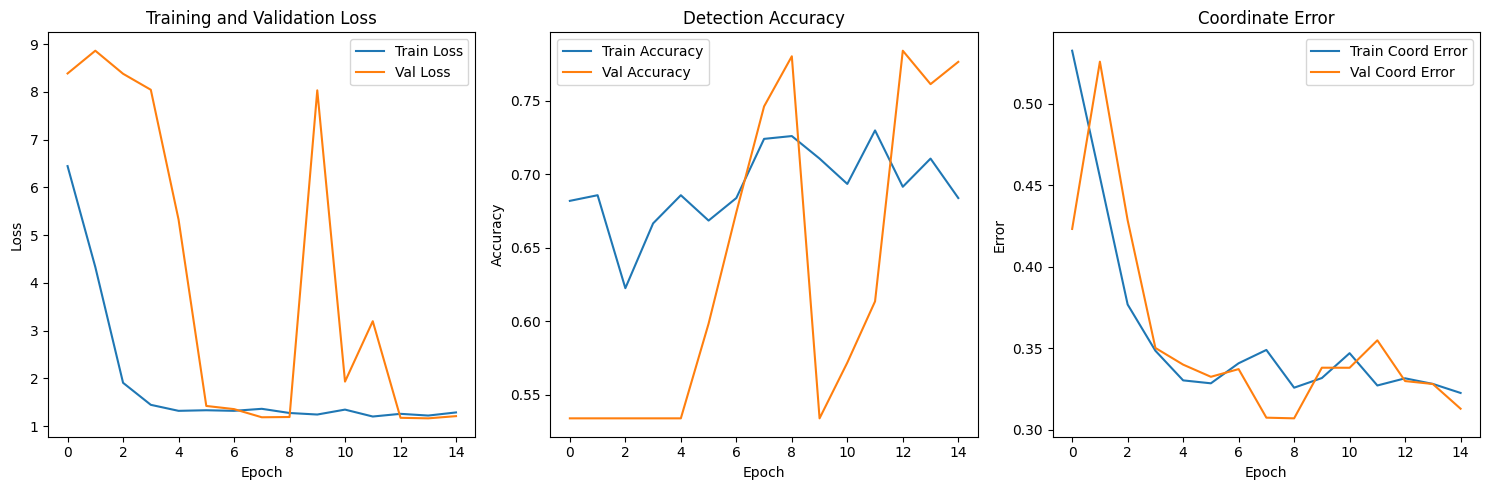


Generating submission
Found 3 tomograms in test directory
Loading model from /kaggle/working/best_motor_model.keras

Processing tomogram 1/3: tomo_003acc
Processing tomogram tomo_003acc with progressive sampling
Found 500 total slices for tomogram tomo_003acc
STAGE 1: Performing coarse sampling with 100 slices (20.0%)


E0000 00:00:1745837747.901755      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745837748.091319      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


[TIMER] Coarse inference: 11.458s
STAGE 2: Found 1 potential detections in coarse scan
Sampling 80 additional slices in region of interest
Total detections before NMS: 81
Detections after NMS: 73
Motor found in tomo_003acc at position: z=217.0, y=1195.8, x=1070.8 with confidence 1.119
Motor found in tomo_003acc at position: z=217, y=1196, x=1071
Current detection rate: 1/1 (100.0%)

Processing tomogram 2/3: tomo_00e047
Processing tomogram tomo_00e047 with progressive sampling
Found 300 total slices for tomogram tomo_00e047
STAGE 1: Performing coarse sampling with 60 slices (20.0%)
[TIMER] Coarse inference: 5.075s
STAGE 2: Found 1 potential detections in coarse scan
Sampling 49 additional slices in region of interest
Total detections before NMS: 50
Detections after NMS: 11
Motor found in tomo_00e047 at position: z=166.0, y=503.5, x=517.9 with confidence 0.758
Motor found in tomo_00e047 at position: z=166, y=504, x=518
Current detection rate: 2/2 (100.0%)

Processing tomogram 3/3: tomo_0

In [13]:
# Run the full pipeline
if __name__ == "__main__":
    # Time entire process
    start_time = time.time()
    
    # Run pipeline
    submission = run_pipeline()
    
    # Print total execution time
    elapsed = time.time() - start_time
    print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

In [14]:
print('FINISHED')

FINISHED
